In [3]:
from __future__ import print_function                                                                                                                                
from imp import reload
import sys
import os
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as LA
import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.interpolate import interp1d
import sympy
from scipy.constants import physical_constants
from sympy.functions.elementary.piecewise import Piecewise
import kwant
from discretizer import Discretizer
from discretizer import momentum_operators, coordinates
from types import SimpleNamespace
from IPython.display import display, Math, Latex
from modules.kp_model.utils import sigma
from modules.parameters import constants
from modules.axial_approximation.solver import solve_cylindrical
sympy.init_printing()
np.set_printoptions(linewidth=np.nan)

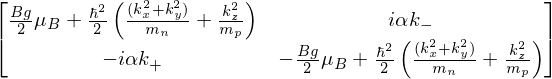

In [4]:
mn, mp, alpha, B, g = sympy.symbols('m_n m_p alpha B g')
hbar, phi_0, mu_B, m0 = sympy.symbols('hbar phi_0 mu_B m_0')
kx, ky, kz = sympy.symbols('k_x k_y k_z')
kp, km, kx2ky2, kx2ky2_kp, kx2ky2_km = sympy.symbols('k_+ k_- (k_x^{2}+k_y^{2}) (k_x^{2}+k_y^{2})k_+ (k_x^{2}+k_y^{2})k_-')
from sympy import I
                               
H = sympy.Matrix([[hbar**2/(2)*(kx2ky2/mn+kz**2/mp)+mu_B/2*g*B,I*alpha*km],
                  [-I*alpha*kp, hbar**2/(2)*(kx2ky2/mn+kz**2/mp)-mu_B/2*g*B]])
H_dict = {
    '0'        : H.subs({kp: 0, km: 0, kx2ky2: 0, kx2ky2_kp: 0, kx2ky2_km: 0}),
    'kp'       : sympy.diff(H,kp),
    'km'       : sympy.diff(H,km),
    'kx2ky2'   : sympy.diff(H,kx2ky2)
}
J = [1/2, -1/2]
H

In [5]:
par = dict(
    m_n  = 0.0416*constants['m_0'],
    m_p  = 0.0370*constants['m_0'],
    alpha = 0.03,
    g = -14.9
)
par.update(constants)

In [6]:
def solve_wire(diameter=80, Nd=401, kz=0, B=0, Fz_max=5/2, n=8, par=par):
    par1 = dict(**par, B=B)
    Fz_list  = np.linspace(-Fz_max,Fz_max,2*Fz_max+1) # list of angular momenta sectors to solve
    E_list = [] # energies
    V_list = [] # states
    S_list = [] # spin expectation values of s-orbital (for g-factor)
    density_list = []
    for fz in Fz_list:
        print(fz)
        E, V = solve_cylindrical(H_dict,J,diameter,Nd,fz,kz,B,par=par1,nsparse=n,solverargs={'sigma':0},phi_0=constants['phi_0'])
        E = E.real
        ind = np.argsort(E)
        E = E[ind]
        V = V[:,ind]

        density = np.abs(V.T)**2
        for i in range(1,2):
            density[:,:Nd] += density[:,i*Nd:(i+1)*Nd]
        density = density[:,:Nd]

        S_list.append([
                2*(LA.norm(v[:Nd])/LA.norm(v)**2-0.5) for v in V.T
            ])

        E_list.append(E)
        V_list.append(V)
        density_list.append(density)
    return E_list, V_list, S_list, density_list

def sort_energies(E_list, V_list, S_list, density_list):
    n = len(E_list[0])
    ind1 = np.argsort(np.array(E_list).flatten().real)
    ind2 = [(i//n,i%n) for i in ind1]

    E = np.array([E_list[i][j] for i,j in ind2]).real                                                                                                                       
    V = np.array([V_list[i][:,j] for i,j in ind2])
    S = np.array([S_list[i][j] for i,j in ind2])
    density = np.array([density_list[i][j] for i,j in ind2])
    return E, V, S, density

-2.5
-1.5
-0.5
0.5
1.5
2.5


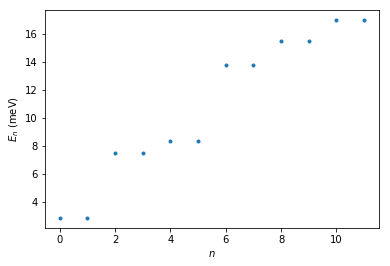

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
B = 1e-6
Nd = 401
diameter = 80
Fz_max = 5/2
Fz_list  = np.linspace(-Fz_max,Fz_max,2*Fz_max+1) 
E_list, V_list, S_list, density_list = solve_wire(B = B, Nd = Nd, diameter = diameter, Fz_max = Fz_max)

n = len(E_list[0])
ind1 = np.argsort(np.array(E_list).flatten().real)
ind2 = [(i//n,i%n) for i in ind1]

E, V, S, density = sort_energies(E_list, V_list, S_list, density_list)

L = np.zeros_like(E)
S = np.zeros_like(E)
for j, _ in enumerate(E):
    for k in range(H.shape[0]):
        vj = V[j, k*Nd:(k+1)*Nd]                                                                                                                                                                                  
        lj = Fz_list[ind2[j][0]]-J[k]
        L[j] += (LA.norm(vj)/LA.norm(V[j, :]))**2*lj
        S[j] += (LA.norm(vj)/LA.norm(V[j, :]))**2*J[k]

plt.figure()
plt.plot(1e3*E[:12],'.')
plt.xlabel('$n$')
plt.ylabel('$E_n$ (meV)')
plt.show()

gfactors = np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/B/constants['mu_B']
display(Math('g = '+', '.join('{:0.2f}'.format(gi) for gi in gfactors)))
display(Latex('$\Delta E_1 = {0:0.2f}\,$meV (analytical {1:0.2f} meV)'.format((E_list[1][0]-E_list[2][1]).real*1e3,
       -1*2*par['m_n']/constants['hbar']**2*par['alpha']**2*1e3)))
display(Latex('$\Delta E_2 = {0:0.2f}\,$meV (analytical {1:0.2f} meV)'.format((E_list[0][0]-E_list[1][1]).real*1e3,
       -2*2*par['m_n']/constants['hbar']**2*par['alpha']**2*1e3)))
for i, e in enumerate(E[:12]):
    display(Latex('$E = {0:2.2f}:\ F_z = {1:+1.1f},\ L_z = {2:+1.2f},\ S_z = {3:+1.2f}$'.format(1e3*e, Fz_list[ind2[i][0]], L[i], S[i])))

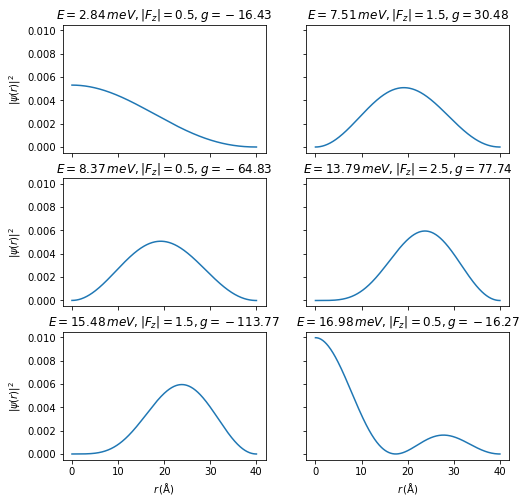

In [8]:
## Norm squared wave functions
E = np.array([E_list[i][j] for i,j in ind2]).real                                                                                                                       
V = np.array([V_list[i][:,j] for i,j in ind2])
S = np.array([S_list[i][j] for i,j in ind2])
density = np.array([density_list[i][j] for i,j in ind2])

Fz_list  = np.linspace(-Fz_max,Fz_max,2*Fz_max+1) 
rho = np.linspace(0,diameter/2,Nd)
fig, axes = plt.subplots(figsize=(8,8),nrows=3,ncols=2, sharey=True,sharex=True)
for i in range(0,12,2):                                                                                                                                      
    ax = axes[i//4,(i//2)%2]
    ax.set_title(r"$E = {0:0.2f}\,meV, |F_z| = {1:0.1f}, g = {2:0.2f}$".format(1e3*E[i],abs(Fz_list[ind2[i][0]]),gfactors[i//2]))
    ax.plot(rho,density[i],label='Fz = '+str(Fz_list[ind2[i][0]]))
for ax in axes[-1,:]:
    ax.set_xlabel(r'$r\,(\mathrm{\AA})$')
for ax in axes[:,0]:
    ax.set_ylabel(r'$|\psi(r)|^2$')
plt.show()

In [9]:
Bv = np.linspace(0,1,51)
energies = []

for B in Bv:
    print(B)
    E_list, V_list, S_list, density_list = solve_wire(B = B, diameter=80)
    E, V, S, density = sort_energies(E_list, V_list, S_list, density_list)
    energies.append(E)
energies = np.array(energies)

0.0
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.02
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.04
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.06
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.08
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.1
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.12
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.14
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.16
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.18
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.2
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.22
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.24
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.26
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.28
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.3
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.32
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.34
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.36
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.38
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.4
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.42
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.44
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.46
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.48
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.5
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.52
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.54
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.56
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.58
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.6
-2.5
-1.5
-0.5
0.5
1.5
2.5
0.62
-2.5
-1.5


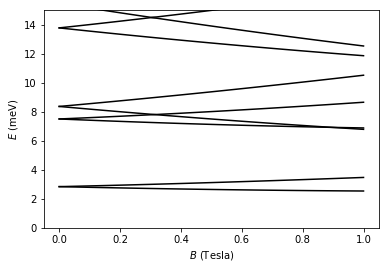

In [10]:
plt.figure()
plt.plot(Bv,1e3*energies[:,:10],'k')
plt.ylim([0,15])
plt.xlabel('$B$ (Tesla)')
plt.ylabel('$E$ (meV)')
plt.show()

In [11]:
## diameter dependence

diameter_list = 10*2**(np.arange(0,29)/4)
energies = []
dE1 = []
dE2 = []

for diameter in diameter_list:
    print(diameter)
    E_list, V_list, S_list, density_list = solve_wire(diameter=diameter, Nd=int(min(max(41,diameter+1),801)))
    E, V, S, density = sort_energies(E_list, V_list, S_list, density_list)
    energies.append(E)
    dE1.append((E_list[1][0]-E_list[2][1]))
    dE2.append((E_list[0][0]-E_list[1][1]))

10.0
-2.5
-1.5
-0.5
0.5
1.5
2.5
11.89207115
-2.5
-1.5
-0.5
0.5
1.5
2.5
14.1421356237
-2.5
-1.5
-0.5
0.5
1.5
2.5
16.8179283051
-2.5
-1.5
-0.5
0.5
1.5
2.5
20.0
-2.5
-1.5
-0.5
0.5
1.5
2.5
23.7841423001
-2.5
-1.5
-0.5
0.5
1.5
2.5
28.2842712475
-2.5
-1.5
-0.5
0.5
1.5
2.5
33.6358566101
-2.5
-1.5
-0.5
0.5
1.5
2.5
40.0
-2.5
-1.5
-0.5
0.5
1.5
2.5
47.5682846001
-2.5
-1.5
-0.5
0.5
1.5
2.5
56.5685424949
-2.5
-1.5
-0.5
0.5
1.5
2.5
67.2717132203
-2.5
-1.5
-0.5
0.5
1.5
2.5
80.0
-2.5
-1.5
-0.5
0.5
1.5
2.5
95.1365692002
-2.5
-1.5
-0.5
0.5
1.5
2.5
113.13708499
-2.5
-1.5
-0.5
0.5
1.5
2.5
134.543426441
-2.5
-1.5
-0.5
0.5
1.5
2.5
160.0
-2.5
-1.5
-0.5
0.5
1.5
2.5
190.2731384
-2.5
-1.5
-0.5
0.5
1.5
2.5
226.27416998
-2.5
-1.5
-0.5
0.5
1.5
2.5
269.086852881
-2.5
-1.5
-0.5
0.5
1.5
2.5
320.0
-2.5
-1.5
-0.5
0.5
1.5
2.5
380.546276801
-2.5
-1.5
-0.5
0.5
1.5
2.5
452.548339959
-2.5
-1.5
-0.5
0.5
1.5
2.5
538.173705762
-2.5
-1.5
-0.5
0.5
1.5
2.5
640.0
-2.5
-1.5
-0.5
0.5
1.5
2.5
761.092553602
-2.5
-1.5
-0.5
0.5
1.5
2.5


<IPython.core.display.Latex object>

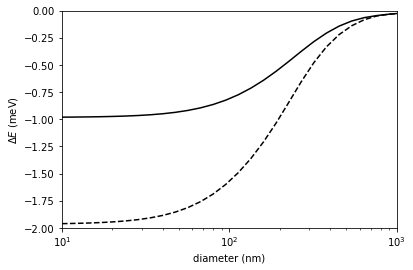

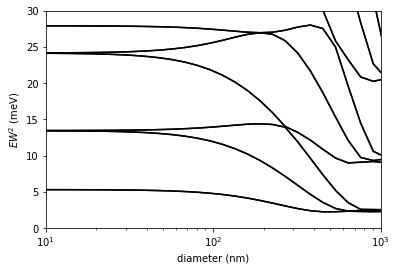

In [12]:
display(Latex('$\Delta E \sim W^{{ {:1.2f} }}$'.format(np.polyfit(np.log(diameter_list)[-2:],np.log(np.abs(dE1[-2:])),1)[0])))

plt.figure()
plt.semilogx(diameter_list,1e3*np.array(dE1),'k')
plt.semilogx(diameter_list,1e3*np.array(dE2),'k--')
plt.xlabel('diameter (nm)')
plt.ylabel('$\Delta E$ (meV)')
plt.ylim([-2,0])
plt.xlim([10,1e3])
plt.show()

eshift = par['m_n']*par['alpha']**2/(2*par['hbar']**2) # bottom of band shifted due to SOC
energies_rescaled = np.array([(e+eshift)*W**2/4 for e, W in zip(energies, diameter_list)])

plt.figure()
plt.semilogx(diameter_list,energies_rescaled,'k')
plt.xlabel('diameter (nm)')
plt.ylabel('$E W^2$ (meV)')
plt.xlim([10,1000])
plt.ylim([0,30])
plt.show()
